In [40]:
import pysam, os, re
import pandas as pd
import seaborn as sns
from collections import Counter
import numpy as np
from pysam import VariantFile
from tqdm import tqdm
from itertools import groupby
from operator import itemgetter
from collections import Counter

In [2]:
chrom_names = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 
          'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 
          'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22']

In [3]:
def result_filtering(comparison_df, min_reads_num, min_variance):
    comparison_df[comparison_df['same_hap_num'] + comparison_df['diff_hap_num'] <= min_reads_num] = comparison_df[comparison_df['same_hap_num'] + comparison_df['diff_hap_num'] <= min_reads_num].assign(myth_phasing_relationship = "cannot decide")
    comparison_df[(abs(comparison_df['same_hap_num'] - comparison_df['diff_hap_num']) / (comparison_df['same_hap_num'] + comparison_df['diff_hap_num'])) <= min_variance] = comparison_df[(abs(comparison_df['same_hap_num'] - comparison_df['diff_hap_num']) / (comparison_df['same_hap_num'] + comparison_df['diff_hap_num'])) <= min_variance].assign(myth_phasing_relationship = "cannot decide")
    return comparison_df

In [4]:
def get_all_final_blocks_dict(block_relationship_df):
    final_block_dict = {}
    for i in range(1,23):
        current_chr = f'chr{i}'
        current_block_relationship_df = block_relationship_df[current_chr]
        current_block_relationship_df_all = current_block_relationship_df[current_block_relationship_df.myth_phasing_relationship != 'cannot decide']  
        
        data = list(current_block_relationship_df_all.index)
        current_chr_index = []
        for k, g in groupby(enumerate(data), lambda ix : ix[0] - ix[1]):
            current_chr_index.append(list(map(itemgetter(1), g)))
        current_block_list = []
        # print(current_chr_index)
        for j in current_chr_index:
            start = eval(current_block_relationship_df_all.loc[j[0]].snp_phased_block_1)[0]
            end = eval(current_block_relationship_df_all.loc[j[-1]].snp_phased_block_2)[1]
            current_block_list.append((start,end))
        current_block_relationship_df_unknown = current_block_relationship_df[current_block_relationship_df.myth_phasing_relationship == 'cannot decide']
        for j in list(current_block_relationship_df.index):
            if j not in data:
                if j == 0:
                    start = eval(current_block_relationship_df.loc[j].snp_phased_block_1)[0]
                    end = eval(current_block_relationship_df.loc[j].snp_phased_block_1)[1]
                    current_block_list.append((start,end))
                start = eval(current_block_relationship_df.loc[j].snp_phased_block_2)[0]
                end = eval(current_block_relationship_df.loc[j].snp_phased_block_2)[1]
                current_block_list.append((start,end))     
        final_block_dict.update({current_chr:current_block_list})

    return final_block_dict

In [5]:
def get_block_relationships(input_folder, min_required_read=0, min_diff_perc=0):
    relationship_df_by_chr = {}
    crr_num = 0
    err_num = 0
    total_len = 0
    for chr_name in chrom_names:
        relationship_df = pd.DataFrame()
        chr_folder_path = os.path.join(input_folder, chr_name)
        for csv_file in sorted(os.listdir(chr_folder_path), key=lambda x: int(x.split('_')[0])):
            csv_file_path = os.path.join(chr_folder_path, csv_file)
            i = pd.read_csv(csv_file_path, index_col=0)[1:].reset_index()
            i = result_filtering(i, min_required_read, min_diff_perc)
            relationship_df = pd.concat([relationship_df, i], ignore_index = True)
            relationship_df_by_chr.update({chr_name: relationship_df})
    return relationship_df_by_chr

In [6]:
def get_altered_block_start_loc(final_blocks, original_block_start_loc):
    for i in final_blocks:
        if original_block_start_loc <= i[1] and original_block_start_loc >= i[0]:
            return str(i[0])
    return -1


In [137]:
def get_altered_vcf(original_vcf, output_vcf, block_relationship_dfs):
    final_block_dict = {}
    called_vcf_file = VariantFile(original_vcf)
    flipping_dict = {}
    remaining_dict = {}
    final_phase_block_dict = {}
    os.makedirs(os.path.dirname(f"./{output_vcf}"), exist_ok=True) 
    with open(output_vcf, "w") as altered_vcf_file:
        altered_vcf_file.writelines(str(called_vcf_file.header))
        for chrom in tqdm(block_relationship_dfs.keys()):
            # chrom = 'chr1'
            current_chrom_final_block = get_all_final_blocks_dict(
                block_relationship_dfs
            )[chrom]
            current_chrom_block_relationship_df = block_relationship_dfs[chrom]
            # print(chrom, len(current_chrom_block_relationship_df))
            final_block_list = []
            flipping_list = []
            block_num = 0
            # print(current_chrom_block_relationship_df)
            while block_num < len(current_chrom_block_relationship_df) - 1:
                current_block_row = current_chrom_block_relationship_df.iloc[block_num]
                if (
                    current_block_row.myth_phasing_relationship == "cannot decide"
                ):  # if the relationship is cannot decide then skip
                    block_num += 1
                else:
                    current_block_start = (
                        current_block_row.snp_phased_block_1
                    )  # collect the assignment of the first block
                    block_start = eval(current_block_start)[0]
                    flipping_list.append((current_block_start, 1))
                    flip_counter = 1  # never flip the first block
                    current_relationship = (
                        current_block_row.myth_phasing_relationship
                    )  # the relationship between this and the next block
                    flip_counter = apply_flip_counter(
                        current_relationship, flip_counter
                    )  # change flip couner into first block and next block
                    current_block_num = block_num
                    block_num += 1
                    # if block_num >= len(current_chrom_block_relationship_df) - 1:
                    #     break
                    # print(flipping_list, block_num)
                    
                    while (
                        (block_num < len(current_chrom_block_relationship_df)) and 
                        (current_chrom_block_relationship_df.iloc[
                            block_num
                        ].myth_phasing_relationship
                        != "cannot decide")
                    ):
                        # print(flipping_list, block_num)
                        flipping_list.append(
                            (
                                current_chrom_block_relationship_df.iloc[
                                    block_num
                                ].snp_phased_block_1,
                                flip_counter,
                            )
                        )  # add flip counter
                        flip_counter = apply_flip_counter(
                            current_chrom_block_relationship_df.iloc[
                                block_num
                            ].myth_phasing_relationship,
                            flip_counter,
                        )  # change flip counter based on previous flip counter, snp block 1 and 2
                        block_num += 1
                    # block_num -= 1
                    flipping_list.append(
                        (
                            current_chrom_block_relationship_df.iloc[
                                block_num - 1
                            ].snp_phased_block_2,
                            flip_counter,
                        )
                    )
                    current_block_length = block_num - current_block_num
                    block_end = eval(
                        current_chrom_block_relationship_df.iloc[
                            block_num - 1
                        ].snp_phased_block_2
                    )[1]
                    final_block_list.append((block_start, block_end))
                    # print(flipping_list)
            final_block_dict.update({chrom: final_block_list})
            flipping_dict.update({chrom: flipping_list})
            unphased_list = []
            for index, i in enumerate(
                current_chrom_block_relationship_df.snp_phased_block_1[:-1]
            ):
                unphased_list.append(
                    (
                        eval(i)[1],
                        eval(
                            current_chrom_block_relationship_df.snp_phased_block_1[
                                index + 1
                            ]
                        )[0],
                    )
                )

            for i in unphased_list:
                called_vcf = called_vcf_file.fetch(chrom, i[0], i[1])
                for rec in called_vcf:
                    rec = str(rec)
                    altered_vcf_file.writelines(rec)
            for i in flipping_list:
                current_block = eval(i[0])
                called_vcf = called_vcf_file.fetch(
                    chrom, current_block[0], current_block[1]
                )
                for rec in called_vcf:
                    rec = str(rec)
                    if i[1] == 1:
                        altered_vcf_file.writelines(rec)
                    else:
                        if "1|0" in rec:
                            if "PS" in rec.split("\t")[-2]:
                                split_rec = rec.split("\t")
                                ps_tag_location = split_rec[-2].split(":").index("PS")
                                start_loc = split_rec[-1].split(":")[ps_tag_location]
                                # print(split_rec, start_loc)
                                split_rec[-1] = split_rec[-1].replace(start_loc, get_altered_block_start_loc(current_chrom_final_block, int(start_loc)))  # type: ignore
                                if split_rec[-2].split(":")[-1] == "PS":
                                    rec = "\t".join(split_rec)
                                    rec = f"{rec}\n"
                                else:
                                    rec = "\t".join(split_rec)
                            altered_vcf_file.writelines(rec.replace("1|0", "0|1"))
                        elif "0|1" in rec:
                            if "PS" in rec.split("\t")[-2]:
                                split_rec = rec.split("\t")
                                ps_tag_location = split_rec[-2].split(":").index("PS")
                                start_loc = split_rec[-1].split(":")[ps_tag_location]
                                # print(split_rec, start_loc)
                                split_rec[-1] = split_rec[-1].replace(start_loc, get_altered_block_start_loc(current_chrom_final_block, int(start_loc)))  # type: ignore
                                if split_rec[-2].split(":")[-1] == "PS":
                                    rec = "\t".join(split_rec)
                                    rec = f"{rec}\n"
                                else:
                                    rec = "\t".join(split_rec)
                            altered_vcf_file.writelines(rec.replace("0|1", "1|0"))
                        else:
                            altered_vcf_file.writelines(rec)
            flpl = [x[0] for x in flipping_list]
            remaining_list = [
                x
                for x in list(current_chrom_block_relationship_df.snp_phased_block_1)
                if x not in flpl
            ]
            if (
                current_chrom_block_relationship_df.iloc[-1].snp_phased_block_2
                not in flpl
            ):
                remaining_list.append(
                    current_chrom_block_relationship_df.iloc[-1].snp_phased_block_2
                )
            remaining_dict.update({chrom: remaining_list})

            for i in remaining_list:
                current_block = eval(i)
                called_vcf = called_vcf_file.fetch(
                    chrom, current_block[0], current_block[1]
                )
                for rec in called_vcf:
                    rec = str(rec)
                    altered_vcf_file.writelines(rec)
    # print(final_block_dict, remaining_dict, flipping_dict, unphased_list)
    return final_block_dict, remaining_dict, flipping_dict

In [8]:
def get_tagged_read_number(input_folder):
    phased_read_list = []
    for chrom in range(1,23):
        current_chrom = f"chr{chrom}"
        assignment_path = os.path.join(input_folder, f"{current_chrom}_read_assignment")
        read_assignment_block_files = os.listdir(assignment_path)
        for j in read_assignment_block_files:
            read_assignment_df = pd.read_csv(os.path.join(assignment_path, j))
            for k in read_assignment_df[read_assignment_df.haplotype != 0].read_id:
                phased_read_list.append(k)
                # print(k)
    return (len(set(phased_read_list)))

In [9]:
def calculate_block_number(methphased_block_df):
    r_30 = 0
    for i in methphased_block_df.keys():
        chr_df = methphased_block_df[i]
        current_chr_df = chr_df[chr_df.myth_phasing_relationship != "cannot decide"]
        # print(len(chr_df), len(current_chr_df))
        r_30 += len(current_chr_df)
    return r_30

In [10]:
def get_whatshap_phase_block_dict(gtf_file):
    phased_block_chr_whatshap_dict = {}
    for i in chrom_names:
        phased_block_df = pd.read_csv(gtf_file, header=None, sep="\t",
            names=["chr","phasing","ex/intron","start","end","1","strand","2","info",],)
        phased_block_df_current_chrom = phased_block_df[phased_block_df.chr == i]
        phased_block_chr_whatshap_dict.update({i: list(zip(phased_block_df_current_chrom["start"], phased_block_df_current_chrom["end"]))})
    return phased_block_chr_whatshap_dict

In [11]:
def get_crr_final_blocks_dict(block_relationship_df):
    final_block_dict = {}
    for i in range(1,23):
        current_chr = f'chr{i}'
        current_block_relationship_df = block_relationship_df[current_chr]
        if "vcf_file_relationship" in current_block_relationship_df:
            current_block_relationship_df_crr = current_block_relationship_df[((current_block_relationship_df.vcf_file_relationship == 'same') & (current_block_relationship_df.myth_phasing_relationship == 'same')) | ((current_block_relationship_df.vcf_file_relationship == 'not same') & (current_block_relationship_df.myth_phasing_relationship == 'not same'))]  
        else:
            current_block_relationship_df_crr = current_block_relationship_df
        data = list(current_block_relationship_df_crr.index)
        current_chr_index = []
        for k, g in groupby(enumerate(data), lambda ix : ix[0] - ix[1]):
            current_chr_index.append(list(map(itemgetter(1), g)))
        current_block_list = []
        for j in current_chr_index:
            start = eval(current_block_relationship_df_crr.loc[j[0]].snp_phased_block_1)[0]
            end = eval(current_block_relationship_df_crr.loc[j[-1]].snp_phased_block_2)[1]
            current_block_list.append((start,end))
        final_block_dict.update({current_chr:current_block_list})
    return final_block_dict

In [12]:
def get_all_final_blocks_dict(block_relationship_df):
    final_block_dict = {}
    for i in range(1,23):
        current_chr = f'chr{i}'
        current_block_relationship_df = block_relationship_df[current_chr]
        # if "vcf_file_relationship" in current_block_relationship_df:
        #     current_block_relationship_df_crr = current_block_relationship_df[((current_block_relationship_df.vcf_file_relationship == 'same') & (current_block_relationship_df.myth_phasing_relationship == 'same')) | ((current_block_relationship_df.vcf_file_relationship == 'not same') & (current_block_relationship_df.myth_phasing_relationship == 'not same'))]  
        current_block_relationship_df_crr = current_block_relationship_df
        data = list(current_block_relationship_df_crr.index)
        current_chr_index = []
        for k, g in groupby(enumerate(data), lambda ix : ix[0] - ix[1]):
            current_chr_index.append(list(map(itemgetter(1), g)))
        current_block_list = []
        for j in current_chr_index:
            start = eval(current_block_relationship_df_crr.loc[j[0]].snp_phased_block_1)[0]
            end = eval(current_block_relationship_df_crr.loc[j[-1]].snp_phased_block_2)[1]
            current_block_list.append((start,end))
        final_block_dict.update({current_chr:current_block_list})
    return final_block_dict

In [13]:
def get_genome_n50(final_block_dict):
    genome_block_len_list = []
    for i in final_block_dict.values():
        for j in i:
            genome_block_len_list.append(j[1]-j[0])
    sum_block_len = 0
    for i in sorted(genome_block_len_list):
        sum_block_len += i
        if sum_block_len > sum(genome_block_len_list)/2:
            return i


In [14]:
def get_whatshap_n50(gtf_file):
    phased_block_chr_whatshap_dict = get_whatshap_phase_block_dict(gtf_file)
    return get_genome_n50(phased_block_chr_whatshap_dict)
def get_methphase_n50(block_relationship_df):
    final_blocks = get_crr_final_blocks_dict(block_relationship_df)
    return get_genome_n50(final_blocks)

In [15]:
def get_whatshap_block_num(gtf_file):
    line_num = 0
    with open(gtf_file, "r") as gf:
        line_num = len(gf.readlines())
    return line_num

In [16]:
def get_untagged_reads(current_block_reads_df, block_start, block_end):
    return current_block_reads_df[current_block_reads_df.ref_start <= block_end]

In [17]:
def get_altered_bam(flipping_dict, remaining_dict, block_relationship_dfs, input_bam_file, original_bam_file, modified_bam_file, assignment_path, chrom):
    input_bam = pysam.AlignmentFile(
        input_bam_file, "rb")
    original_bam = pysam.AlignmentFile(
        original_bam_file, "rb")
    modified_bam = pysam.AlignmentFile(
        modified_bam_file, "wb", template=original_bam)


    sorted_read_assignment_files = sorted(os.listdir(
        assignment_path), key=lambda x: int(x.split('_')[0]))
    # print(sorted_read_assignment_files)
    # return
    flipping_dict_chom = dict(flipping_dict[chrom])
    # snp block that does not have relationship assignment are not affected.
    snp_block_flipping_chom = dict(
        zip(remaining_dict[chrom], [1]*len(remaining_dict[chrom])))
    snp_block_flipping_chom.update(flipping_dict_chom)
    overlapped_reads_list = []
    
    # reads_before_first_block = input_bam.fetch(
    #     chrom, 0, int(sorted_read_assignment_files[0].split('-')[0]))
    # for reads in reads_before_first_block:
    #     modified_bam.write(reads)
    # reads_after_last_block = input_bam.fetch(chrom, int(re.split('-|\.', sorted_read_assignment_files[-1])[1]), input_bam.get_reference_length(chrom))
    # for reads in reads_after_last_block:
    #     modified_bam.write(reads)
    for index, i in tqdm(enumerate(sorted_read_assignment_files)):
        # the vital part is to deal with the overlapped reads
        splitted_block_name = re.split("\\.|_", i)
        current_block = f"({splitted_block_name[1]}, {splitted_block_name[2]})" # extended block
        current_block_reads_f_path = os.path.join(assignment_path, i)
        if index < len(sorted_read_assignment_files)-1:
            next_block_reads_f_path = os.path.join(
                assignment_path, sorted_read_assignment_files[index+1])  # why we need sorted file names
            next_block_reads_df = pd.read_csv(next_block_reads_f_path)
        if index == len(sorted_read_assignment_files) - 1:
            current_snp_block = block_relationship_dfs[chrom].snp_phased_block_2[index-1]
        else:
            current_snp_block = block_relationship_dfs[chrom].snp_phased_block_1[index]
            
        current_block_reads_df = pd.read_csv(current_block_reads_f_path)
        
        current_block_reads_df = current_block_reads_df[current_block_reads_df.ref_start <= eval(current_snp_block)[1]]
        
        current_block_reads_df = current_block_reads_df[~current_block_reads_df.read_id.isin(
            overlapped_reads_list)]  # remove reads that overlapped with the previous block

        current_block_reads = input_bam.fetch(chrom, int(splitted_block_name[1]), eval(current_snp_block)[1])  # fetch reads with this block
        read_to_hp_dict = dict(
            zip(current_block_reads_df['read_id'], current_block_reads_df['haplotype']))
        current_flip_flag = snp_block_flipping_chom[current_snp_block]
        if current_flip_flag == 1:
            for reads in current_block_reads:
                # if the read is overlapped with previous block's reads, it should not be re-assigned
                if reads.query_name not in overlapped_reads_list:
                    # previously unhaplotagged
                    if reads.query_name in list(current_block_reads_df.read_id):
                        if read_to_hp_dict[reads.query_name] == 1:
                            reads.set_tag(tag='HP', value=1, value_type='i')
                            modified_bam.write(reads)
                        elif read_to_hp_dict[reads.query_name] == 2:
                            reads.set_tag(tag='HP', value=2, value_type='i')
                            modified_bam.write(reads)
                        else:  # still unhaplotagged
                            modified_bam.write(reads)
                    else:
                        # not modifying the previous reads, just output.
                        modified_bam.write(reads)
        elif current_flip_flag == -1:
            for reads in current_block_reads:
                # if the read is overlapped with previous reads, it should not be re-assigned
                if reads.query_name not in overlapped_reads_list:
                    # previously unhaplotagged
                    if reads.query_name in list(current_block_reads_df.read_id):
                        if read_to_hp_dict[reads.query_name] == 1:  # switch
                            reads.set_tag(tag='HP', value=2, value_type='i')
                            print('3b81e4c2-6d4f-48d0-ab2d-055fa69f8141', 'Has HP tag 1, no switch')
                            modified_bam.write(reads)
                        elif read_to_hp_dict[reads.query_name] == 2:
                            reads.set_tag(tag='HP', value=1, value_type='i')
                            print('3b81e4c2-6d4f-48d0-ab2d-055fa69f8141', 'Has HP tag 2, no switch')
                            modified_bam.write(reads)
                        else:  # still unhaplotagged
                            modified_bam.write(reads)
                    else:
                        if reads.has_tag('HP'):  # switch already called ones
                            if reads.get_tag('HP') == 1:
                                reads.set_tag(tag='HP', value=2,
                                              value_type='i')
                                print('3b81e4c2-6d4f-48d0-ab2d-055fa69f8141', 'Has HP tag 1')
                                modified_bam.write(reads)
                            elif reads.get_tag('HP') == 2:
                                print('3b81e4c2-6d4f-48d0-ab2d-055fa69f8141', 'Has HP tag 2')
                                reads.set_tag(tag='HP', value=1,
                                              value_type='i')
                                modified_bam.write(reads)
                    # all previously unhaplotagged reads were considered before
        # print(len(overlapped_reads_list))
        overlapped_reads_list = list(next_block_reads_df[next_block_reads_df.read_id.isin(list(current_block_reads_df.read_id))].read_id)  # update the list to current and next block's overlaps
        # if 'd0aac57a-3d69-40a4-9ded-4b879a6679e9' in overlapped_reads_list: print('d0aac57a-3d69-40a4-9ded-4b879a6679e9', overlapped_reads_list)
    modified_bam.close()

In [18]:
def get_chrom_n50(final_block_dict):
    chrom_n50 = {}
    for chrom in final_block_dict.keys():
        block_len_list = []
        for i in final_block_dict[chrom]:
            block_len_list.append(i[1]-i[0])
        sum_block_len = 0
        for i in sorted(block_len_list, reverse=False):
            sum_block_len += i
            if sum_block_len > sum(block_len_list)/2:
                chrom_n50.update({chrom:i})
                break
    return chrom_n50

In [243]:
block_relationships_df_30x_high_acc = get_block_relationships("/data/yf20/meth_phasing/30x/whole_genome_6/", 8, 0.5)
final_block_dict_30x, remaining_dict_30x, flipping_dict_30x = get_altered_vcf("/data/yf20/meth_phasing/30x/30x.filtered.phased.VCF.gz", "/data/yf20/meth_phasing/30x/30x.filtered.alteded.vcf", block_relationships_df_30x_high_acc)

100%|██████████| 22/22 [00:41<00:00,  1.90s/it]


In [188]:
block_relationships_df_60x_high_acc = get_block_relationships("/data/yf20/meth_phasing/60x/whole_genome_6/", 15, 0.5)
final_block_dict_60x, remaining_dict_60x, flipping_dict_60x = get_altered_vcf("/data/yf20/meth_phasing/60x/60x.filtered.txt.phased.VCF.gz", "/data/yf20/meth_phasing/60x/60x.filtered.altered.vcf", block_relationships_df_60x_high_acc)

100%|██████████| 22/22 [00:33<00:00,  1.54s/it]


In [38]:
block_relationships_df_LSK60x_high_acc = get_block_relationships("/data/yf20/meth_phasing/LSK/whole_genome_6/", 15, 0.5)
final_block_dict_LSK_60x, remaining_dict_LSK_60x, flipping_dict_LSK_60x = get_altered_vcf("/data/yf20/meth_phasing/LSK/LSK.phased.blocks.phased.VCF.gz", "/data/yf20/meth_phasing/LSK/LSK60x.filtered.altered.vcf", block_relationships_df_LSK60x_high_acc)

100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


In [386]:
block_relationships_df_LSK30x_high_acc = get_block_relationships("/data/yf20/meth_phasing/LSK30X/whole_genome_6/", 8, 0.5)
final_block_dict_LSK30x, remaining_dict_LSK30x, flipping_dict_LSK30x = get_altered_vcf("/data/yf20/meth_phasing/LSK30X/LSK30X.phased.blocks.phased.VCF.gz", "/data/yf20/meth_phasing/LSK30X/LSK30x.filtered.altered.vcf", block_relationships_df_LSK30x_high_acc)

100%|██████████| 22/22 [00:22<00:00,  1.03s/it]


In [377]:
block_relationships_df_80x_high_acc = get_block_relationships("/data/yf20/meth_phasing/80x/whole_genome_7/", 20, 0.5)
final_block_dict_30x, remaining_dict_30x, flipping_dict_30x = get_altered_vcf("/data/yf20/meth_phasing/80x/80x.called.phased_blocks.regions.txt.phased.VCF.gz", "/data/yf20/meth_phasing/80x/80x.filtered.altered.vcf", block_relationships_df_80x_high_acc)

100%|██████████| 22/22 [00:44<00:00,  2.02s/it]


In [180]:
block_relationships_df_60x_high_sr = get_block_relationships("/data/yf20/meth_phasing/60x/whole_genome_6/", 0, 0)
final_block_dict_sr_60x, remaining_dict_sr_60x, flipping_dict_sr_60x = get_altered_vcf("/data/yf20/meth_phasing/60x/60x.filtered.txt.phased.VCF.gz", "/data/yf20/meth_phasing/60x/60x.filtered.altered.high.sr.vcf", block_relationships_df_60x_high_sr)

100%|██████████| 22/22 [00:26<00:00,  1.21s/it]


In [389]:
get_chrom_n50(final_block_dict_LSK30x)

{'chr1': 3166893,
 'chr2': 1909444,
 'chr3': 3110131,
 'chr4': 4620516,
 'chr5': 3233597,
 'chr6': 2667030,
 'chr7': 2881244,
 'chr8': 2842318,
 'chr9': 3359831,
 'chr10': 3006846,
 'chr11': 2908713,
 'chr12': 2997087,
 'chr13': 4382530,
 'chr14': 3046975,
 'chr15': 3155371,
 'chr16': 1768165,
 'chr17': 3259489,
 'chr18': 3211004,
 'chr19': 2278852,
 'chr20': 3875227,
 'chr21': 5705649,
 'chr22': 6116840}

In [390]:
get_chrom_n50(get_whatshap_phase_block_dict("/data/yf20/meth_phasing/LSK30X/LSK30X.filtered.gtf"))

{'chr1': 1672792,
 'chr2': 1421262,
 'chr3': 1757301,
 'chr4': 2177673,
 'chr5': 2277321,
 'chr6': 1764402,
 'chr7': 1693540,
 'chr8': 1731173,
 'chr9': 1920489,
 'chr10': 1591087,
 'chr11': 1757484,
 'chr12': 1559145,
 'chr13': 1982929,
 'chr14': 1809327,
 'chr15': 1524211,
 'chr16': 1447782,
 'chr17': 1408466,
 'chr18': 1554796,
 'chr19': 1686347,
 'chr20': 1944123,
 'chr21': 1679614,
 'chr22': 1703591}

In [36]:
def get_genome_nx(final_block_dict, nx):
    genome_block_len_list = []
    for i in final_block_dict.values():
        for j in i:
            genome_block_len_list.append(j[1]-j[0])
    sum_block_len = 0
    for i in sorted(genome_block_len_list):
        sum_block_len += i
        if sum_block_len > sum(genome_block_len_list)*nx:
            return i



def get_whatshap_nx(gtf_file, nx):
    phased_block_chr_whatshap_dict = get_whatshap_phase_block_dict(gtf_file)
    return get_genome_nx(phased_block_chr_whatshap_dict, nx)
def get_methphase_nx(block_relationship_df, nx):
    final_blocks = get_crr_final_blocks_dict(block_relationship_df)
    return get_genome_nx(final_blocks, nx)

In [114]:
whatshap_nx_curve = []
methphase_nx_curve = []
for i in np.linspace(0.1, 0.9, 9):
    whatshap_nx_curve.append(get_whatshap_nx("/data/yf20/meth_phasing/LSK/LSK.filtered.gtf", i))
    methphase_nx_curve.append(get_methphase_nx(block_relationships_df_LSK60x_high_acc, i))

Text(0.5, 1.0, 'N10-N90 Curve')

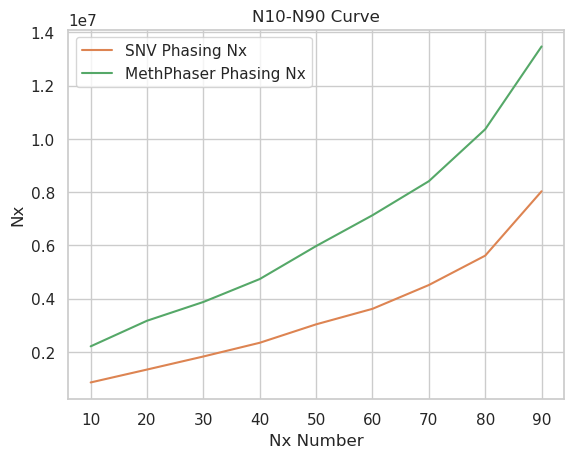

In [117]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,1)
x_lables =[str(int(x)) for x in np.linspace(10, 90, 9)]
# sns.lineplot(, y=y_values1, label="Line 1")
line0 = sns.lineplot(x=x_lables, ax=axes)
line1 = sns.lineplot(data=whatshap_nx_curve,  ax=axes, label="SNV Phasing Nx")
line2 = sns.lineplot(data=methphase_nx_curve,  ax=axes, label="MethPhaser Phasing Nx")
# plt.xticks(x_lables, rotation=45)

plt.xlabel("Nx Number")
plt.ylabel("Nx")
plt.title("N10-N90 Curve")
# (whatshap_nx_curve, methphase_nx_curve)

In [104]:
x_lables

['10', '20', '30', '40', '50', '60', '70', '80', '90', '100']

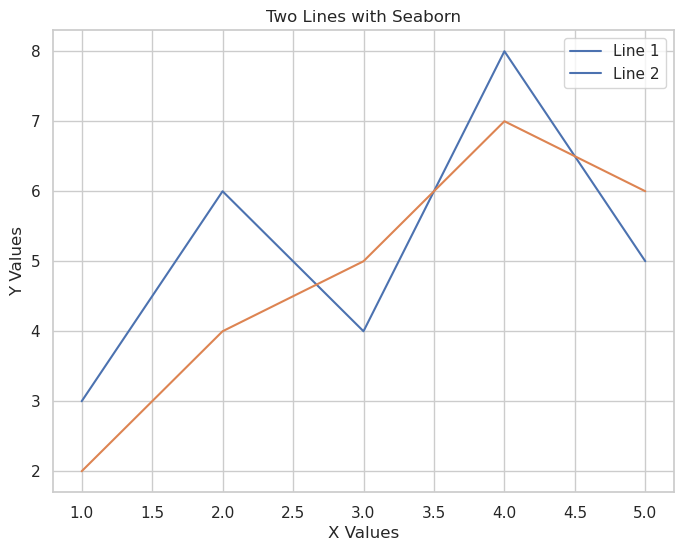

In [70]:

# Two lists of data
x_values = [1, 2, 3, 4, 5]
y_values1 = [3, 6, 4, 8, 5]
y_values2 = [2, 4, 5, 7, 6]

# Create a Seaborn lineplot
sns.set(style="whitegrid")  # Set the style of the plot
plt.figure(figsize=(8, 6))  # Set the figure size

# Plot the first line
line1 = sns.lineplot(x=x_values, y=y_values1, label="Line 1")

# Plot the second line
line2 = sns.lineplot(x=x_values, y=y_values2, label="Line 2")

# Add labels and title
plt.xlabel("X Values")
plt.ylabel("Y Values")
plt.title("Two Lines with Seaborn")

# Customize legend
plt.legend(handles=[line1.lines[0], line2.lines[0]], labels=['Line 1', 'Line 2'])

# Show the plot
plt.show()

In [ ]:

print(
    get_whatshap_n50("/data/yf20/meth_phasing/30x/30x.filtered.gtf"),
    get_whatshap_n50("/data/yf20/meth_phasing/60x/60x.filtered.gtf"),
    get_whatshap_n50("/data/yf20/meth_phasing/LSK/LSK.filtered.gtf"),
    get_whatshap_n50("/data/yf20/meth_phasing/LSK30X/LSK30X.filtered.gtf"),
    get_whatshap_n50("/data/yf20/meth_phasing/80x/80x.called.regions.gtf"),
    get_methphase_n50(block_relationships_df_30x_high_acc),
    get_methphase_n50(block_relationships_df_60x_high_acc),
    get_methphase_n50(block_relationships_df_LSK60x_high_acc),
    get_methphase_n50(block_relationships_df_LSK30x_high_acc),
    get_methphase_n50(block_relationships_df_80x_high_acc)
)

1277625 1706719 3034229 1720208 1904864 2279142 3997227 5975765 3152506 4824056


In [379]:
print(
    calculate_block_number(block_relationships_df_30x_high_acc),
    calculate_block_number(block_relationships_df_60x_high_acc),
    calculate_block_number(block_relationships_df_LSK30x_high_acc),
    calculate_block_number(block_relationships_df_LSK60x_high_acc),
    calculate_block_number(block_relationships_df_80x_high_acc)
)

1026 1457 571 648 1440


In [380]:
print(
    get_whatshap_block_num("/data/yf20/meth_phasing/30x/30x.filtered.gtf"),
    get_whatshap_block_num("/data/yf20/meth_phasing/60x/60x.filtered.gtf"),
    get_whatshap_block_num("/data/yf20/meth_phasing/LSK/LSK.filtered.gtf"),
    get_whatshap_block_num("/data/yf20/meth_phasing/LSK30X/LSK30X.filtered.gtf"),
    get_whatshap_block_num("/data/yf20/meth_phasing/80x/80x.called.regions.gtf"),
)

4518 3179 1820 3068 2839


In [65]:
print(
    get_tagged_read_number("/data/yf20/meth_phasing/LSK30X/whole_genome_6/"),
    get_tagged_read_number("/data/yf20/meth_phasing/LSK/whole_genome_6/"),
    get_tagged_read_number("/data/yf20/meth_phasing/30x/whole_genome_6/"),
    get_tagged_read_number("/data/yf20/meth_phasing/60x/whole_genome_6/"),
    get_tagged_read_number("/data/yf20/meth_phasing/80x/whole_genome_7/"),
)

802529 1867831 501170 1138593 1534961


In [42]:

def get_connected_homozygous_rgions(block_relationship_dfs):
    for i in range(1,23):
        current_chr = f'chr{i}'
        current_block_relationship_df_crr = current_block_relationship_df[((current_block_relationship_df.vcf_file_relationship == 'same') & (current_block_relationship_df.myth_phasing_relationship == 'same')) | ((current_block_relationship_df.vcf_file_relationship == 'not same') & (current_block_relationship_df.myth_phasing_relationship == 'not same'))]  
    return


In [28]:
def output_gtf(final_blocks_dict, gtf_file):
    with open(gtf_file, "w") as gf:
        for keys in final_blocks_dict.keys():
            for blocks in final_blocks_dict[keys]:
                gf.writelines(f"{keys}\tPhasing\texon\t{blocks[0]}\t{blocks[1]}\t.\t+\t.\tgene_id \"{blocks[0]}\"; transcript_id \"{blocks[0]}.1\";\n")

In [60]:
output_gtf(get_crr_final_blocks_dict(block_relationships_df_LSK60x_high_acc), "/data/yf20/meth_phasing/LSK/LSK.methphased.gtf")

In [182]:
def get_all_crr_final_blocks_dict(block_relationship_df):
    final_block_dict = {}
    for i in range(1,23):
        current_chr = f'chr{i}'
        current_block_relationship_df = block_relationship_df[current_chr]
        current_block_relationship_df_crr = current_block_relationship_df[((current_block_relationship_df.vcf_file_relationship == 'same') & (current_block_relationship_df.myth_phasing_relationship == 'same')) | ((current_block_relationship_df.vcf_file_relationship == 'not same') & (current_block_relationship_df.myth_phasing_relationship == 'not same'))]  
        data = list(current_block_relationship_df_crr.index)
        current_chr_index = []
        for k, g in groupby(enumerate(data), lambda ix : ix[0] - ix[1]):
            current_chr_index.append(list(map(itemgetter(1), g)))
        # print(current_chr_index)
        current_block_list = []
        for j in current_chr_index:
            # print(j)
            start = eval(current_block_relationship_df_crr.loc[j[0]].snp_phased_block_1)[0]
            end = eval(current_block_relationship_df_crr.loc[j[-1]].snp_phased_block_2)[1]
            current_block_list.append((start,end))
        # print(data)
        for j in list(current_block_relationship_df.index)[:-1]:
            if j not in data:
                   
                if j == 0:
                    start = eval(current_block_relationship_df.loc[j].snp_phased_block_1)[0]
                    end = eval(current_block_relationship_df.loc[j].snp_phased_block_1)[1]
                    current_block_list.append((start,end))
                if j+1 not in data:
                    start = eval(current_block_relationship_df.loc[j].snp_phased_block_2)[0]
                    end = eval(current_block_relationship_df.loc[j].snp_phased_block_2)[1]
                    # print(j,(start,end), end=" ")
                    current_block_list.append((start,end))     
        final_block_dict.update({current_chr:current_block_list})

    return final_block_dict

In [25]:
def get_all_final_blocks_dict_no_snp(block_relationship_df):
    final_block_dict = {}
    for i in range(1,23):
        current_chr = f'chr{i}'
        current_block_relationship_df = block_relationship_df[current_chr]
        current_block_relationship_df_crr = current_block_relationship_df[current_block_relationship_df.myth_phasing_relationship != 'cannot decide']  
        # current_block_relationship_df_crr = current_block_relationship_df
        data = list(current_block_relationship_df_crr.index)
        current_chr_index = []
        for k, g in groupby(enumerate(data), lambda ix : ix[0] - ix[1]):
            current_chr_index.append(list(map(itemgetter(1), g)))
        # print(current_chr_index)
        current_block_list = []
        for j in current_chr_index:
            # print(j)
            start = eval(current_block_relationship_df_crr.loc[j[0]].snp_phased_block_1)[0]
            end = eval(current_block_relationship_df_crr.loc[j[-1]].snp_phased_block_2)[1]
            current_block_list.append((start,end))
        # print(data)
        for j in list(current_block_relationship_df.index)[:-1]:
            if j not in data:
                if j == 0:
                    start = eval(current_block_relationship_df.loc[j].snp_phased_block_1)[0]
                    end = eval(current_block_relationship_df.loc[j].snp_phased_block_1)[1]
                    current_block_list.append((start,end))
                if j+1 not in data:
                    start = eval(current_block_relationship_df.loc[j].snp_phased_block_2)[0]
                    end = eval(current_block_relationship_df.loc[j].snp_phased_block_2)[1]
                    # print(j,(start,end), end=" ")
                    current_block_list.append((start,end))
                if j+2 == len(current_block_relationship_df):
                    start = eval(current_block_relationship_df.loc[j+1].snp_phased_block_2)[0]
                    end = eval(current_block_relationship_df.loc[j+1].snp_phased_block_2)[1]
                    current_block_list.append((start,end))
        final_block_dict.update({current_chr:current_block_list})
                    
    return final_block_dict

# Medical relevant genes

In [298]:
def get_linked_gene_num(methphase_block, gene):
    chr_relevance_meth_phasing_list = list(zip(methphase_block, gene))
    chr_relevance_meth_phasing_dict = {}
    for i in chr_relevance_meth_phasing_list:
        if i[0] not in list(chr_relevance_meth_phasing_dict.keys()):
            chr_relevance_meth_phasing_dict.update({i[0]: [i[1]]})
        else:
            chr_relevance_meth_phasing_dict[i[0]].append(i[1])
    total_meth_phase_linked_num_list = []
    for i in chr_relevance_meth_phasing_dict.keys():
        if i != None:
            total_meth_phase_linked_num_list.append(len(chr_relevance_meth_phasing_dict[i])) 
    return total_meth_phase_linked_num_list

In [299]:
def get_block_lists(cmrg_benchmark,lsk_meth_phase_final_blocks, lsk_hapcut2_final_blocks):
    meth_phase_block_list = []
    meth_phase_block_dict_per_chr = {}
    snp_phase_block_list = []
    snp_phase_block_dict_per_chr = {}
    for index, i in cmrg_benchmark.iterrows():
        meth_phase_block_list_chr = []
        meth_phase_found_flag = 0
        for j in lsk_meth_phase_final_blocks[i.chr]:
            if i.start < j[1] and i.end > j[0]:
                meth_phase_block_list.append(j)
                meth_phase_found_flag = 1
                break
        if meth_phase_found_flag == 0:
            meth_phase_block_list.append(None)

        snp_phase_block_list_chr = []
        snp_phase_found_flag = 0    
        for j in lsk_hapcut2_final_blocks[i.chr]:
            if i.start < j[1] and i.end > j[0]:
                snp_phase_block_list.append(j)
                snp_phase_found_flag = 1
                break
        if snp_phase_found_flag == 0:
            snp_phase_block_list.append(None)
    return meth_phase_block_list, snp_phase_block_list

In [304]:
def get_linked_relevent_gene_dict(cmrg_benchmark): 
    linked_relevent_gene_dict = {}
    for j in range(1,23):
        cmrg_bench_chr = cmrg_benchmark[cmrg_benchmark['chr']==f"chr{j}"]
        meth_linked_gene_num = get_linked_gene_num(cmrg_bench_chr.methphase_block, cmrg_bench_chr.gene)
        snp_linked_gene_num = get_linked_gene_num(cmrg_bench_chr.snp_phase_block, cmrg_bench_chr.gene)
        linked_relevent_gene_dict.update({f"chr{j}":(meth_linked_gene_num, snp_linked_gene_num)})
    return linked_relevent_gene_dict

In [305]:
# 273 gene file
cmrg_benchmark = pd.read_csv("/data/yf20/meth_phasing/GRCh38_CMRG_benchmark_gene_coordinates.bed", sep="\t", header=None, names=['chr', 'start', 'end', "gene"])


In [196]:
(pd.DataFrame.from_dict(linked_relevent_gene_dict)).to_csv("/data/yf20/meth_phasing/medical_relevance_gene_comparison.csv")
medical_relevance_df = pd.read_excel("/data/yf20/meth_phasing/2021 Gene Panel LR.xlsx", names=['chr', 'start', 'end', "length", "gene", "relevance"], index_col=False)

In [337]:
block_relationships_df_HG01109_high_acc = get_block_relationships("/data/yf20/meth_phasing/HG01109/whole_genome_1/", 8, 0.3)
final_block_dict_HG01109, remaining_dict_HG01109, flipping_dict_HG01109 = get_altered_vcf("/data/yf20/meth_phasing/HG01109/HG01109.called.phased_blocks.txt.phased.VCF.gz", "/data/yf20/meth_phasing/HG01109/HG01109.filtered.alteded.vcf", block_relationships_df_HG01109_high_acc)
block_relationships_df_HG02080_high_acc = get_block_relationships("/data/yf20/meth_phasing/HG02080/whole_genome_1/", 8, 0.3)
final_block_dict_HG02080, remaining_dict_HG02080, flipping_dict_HG02080 = get_altered_vcf("/data/yf20/meth_phasing/HG02080/HG02080.called.phased_blocks.txt.phased.VCF.gz", "/data/yf20/meth_phasing/HG02080/HG02080.filtered.alteded.vcf", block_relationships_df_HG02080_high_acc)
block_relationships_df_HG03098_high_acc = get_block_relationships("/data/yf20/meth_phasing/HG03098/whole_genome_1/", 8, 0.3)
final_block_dict_HG03098, remaining_dict_HG03098, flipping_dict_HG03098 = get_altered_vcf("/data/yf20/meth_phasing/HG03098/HG03098.called.phased_blocks.txt.phased.VCF.gz", "/data/yf20/meth_phasing/HG03098/HG03098.filtered.alteded.vcf", block_relationships_df_HG03098_high_acc)

100%|██████████| 22/22 [00:55<00:00,  2.52s/it]


In [368]:
HG01109_meth_phase_final_blocks = get_all_final_blocks_dict_no_snp(block_relationships_df_HG01109_high_acc)
output_gtf(HG01109_meth_phase_final_blocks, "/data/yf20/meth_phasing/HG01109/HG01109.methtagged.gtf")
HG02080_meth_phase_final_blocks = get_all_final_blocks_dict_no_snp(block_relationships_df_HG02080_high_acc)
output_gtf(HG02080_meth_phase_final_blocks, "/data/yf20/meth_phasing/HG02080/HG02080.methtagged.gtf")
HG03098_meth_phase_final_blocks = get_all_final_blocks_dict_no_snp(block_relationships_df_HG03098_high_acc)
output_gtf(HG03098_meth_phase_final_blocks, "/data/yf20/meth_phasing/HG03098/HG03098.methtagged.gtf")

In [300]:
#pangenome 
HG01109_snp_block = get_whatshap_phase_block_dict("/data/yf20/meth_phasing/HG01109/HG01109.gtf")
HG02080_snp_block = get_whatshap_phase_block_dict("/data/yf20/meth_phasing/HG02080/HG02080.gtf")
HG03098_snp_block = get_whatshap_phase_block_dict("/data/yf20/meth_phasing/HG03098/HG03098.gtf")


In [369]:
HG01109_meth_med_block, HG01109_snp_med_block = get_block_lists(cmrg_benchmark, HG01109_meth_phase_final_blocks, HG01109_snp_block)
HG02080_meth_med_block, HG02080_snp_med_block = get_block_lists(cmrg_benchmark, HG02080_meth_phase_final_blocks, HG02080_snp_block)
HG03098_meth_med_block, HG03098_snp_med_block = get_block_lists(cmrg_benchmark, HG03098_meth_phase_final_blocks, HG03098_snp_block)

In [373]:
cmrg_benchmark['HG01109_meth_med_block'] = HG01109_meth_med_block
print(len(set(HG01109_meth_med_block)))
cmrg_benchmark['HG01109_snp_med_block'] = HG01109_snp_med_block
print(len(set(HG01109_snp_med_block)))
cmrg_benchmark['HG02080_meth_med_block'] = HG02080_meth_med_block
print(len(set(HG02080_meth_med_block)))
cmrg_benchmark['HG02080_snp_med_block'] = HG02080_snp_med_block
print(len(set(HG02080_snp_med_block)))
cmrg_benchmark['HG03098_meth_med_block'] = HG03098_meth_med_block
print(len(set(HG03098_meth_med_block)))
cmrg_benchmark['HG03098_snp_med_block'] = HG03098_snp_med_block
print(len(set(HG03098_snp_med_block)))

76
81
113
123
96
108


In [409]:
LSK30X_snp_block = get_whatshap_phase_block_dict("/data/yf20/meth_phasing/LSK30X/LSK30X.filtered.gtf")
# block_relationships_df_LSK30x_high_acc = get_block_relationships("/data/yf20/meth_phasing/LSK30X/whole_genome_6/", 8, 0.5)
final_block_dict_LSK30x = get_all_crr_final_blocks_dict(block_relationships_df_LSK30x_high_acc)

LSK30X_meth_med_block,LSK30X_snp_med_block = get_block_lists(cmrg_benchmark, final_block_dict_LSK30x, LSK30X_snp_block)

In [410]:
cmrg_benchmark['LSK30X_meth_med_block'] = LSK30X_meth_med_block
print(len(set(LSK30X_meth_med_block)))
cmrg_benchmark['LSK30X_snp_med_block'] = LSK30X_snp_med_block
print(len(set(LSK30X_snp_med_block)))

154
169


In [411]:
cmrg_benchmark.to_csv("/data/yf20/meth_phasing/pangenome_medical.csv")

In [375]:
r10_60x_snp_block = get_whatshap_phase_block_dict("/data/yf20/meth_phasing/LSK/LSK.filtered.gtf")

In [383]:
r10_60x_meth_med_block, r10_60x_snp_med_block = get_block_lists(cmrg_benchmark, r10_60x_meth_phase_final_blocks, r10_60x_snp_block)

cmrg_benchmark['LSK_meth_med_block'] = r10_60x_meth_med_block
cmrg_benchmark['LSK_snp_med_block'] = r10_60x_snp_med_block

In [384]:
cmrg_benchmark.to_csv("/data/yf20/meth_phasing/pangenome_medical.csv")

In [382]:
print(len(set(r10_60x_meth_med_block)), len(set(r10_60x_snp_med_block)))
print(len([i for i in r10_60x_meth_med_block if i is not None]), len([i for i in r10_60x_snp_med_block if i is not None]))

140 160
255 258


In [370]:
r9_30x_meth_phase_final_blocks = get_all_crr_final_blocks_dict(block_relationships_df_30x_high_acc)
output_gtf(r9_30x_meth_phase_final_blocks, "/data/yf20/meth_phasing/30x/30x.methtagged.gtf")

In [371]:
r9_60x_meth_phase_final_blocks = get_all_crr_final_blocks_dict(block_relationships_df_60x_high_acc)
output_gtf(r9_60x_meth_phase_final_blocks, "/data/yf20/meth_phasing/60x/60x.methtagged.gtf")

In [185]:
r9_60x_meth_phase_final_blocks_high_sr = get_all_crr_final_blocks_dict(block_relationships_df_60x_high_sr)
output_gtf(r9_60x_meth_phase_final_blocks_high_sr, "/data/yf20/meth_phasing/60x/60x.methtagged.high.sr.gtf")

In [372]:
r10_30x_meth_phase_final_blocks = get_all_crr_final_blocks_dict(block_relationships_df_LSK30x_high_acc)
output_gtf(r10_30x_meth_phase_final_blocks, "/data/yf20/meth_phasing/LSK30X/LSK30X.methtagged.gtf")

In [377]:
r10_60x_meth_phase_final_blocks = get_all_crr_final_blocks_dict(block_relationships_df_LSK60x_high_acc)
output_gtf(r10_60x_meth_phase_final_blocks, "/data/yf20/meth_phasing/LSK/LSK.methtagged.gtf")

In [ ]:
r9_80x_meth_phase_final_blocks = get_all_crr_final_blocks_dict(block_relationships_df_80x_high_acc)
output_gtf(r9_80x_meth_phase_final_blocks, "/data/yf20/meth_phasing/80x/80x.methtagged.gtf")

In [33]:
def get_unphased_len(input_phased_block_dict):
    total_unphased_len = 0
    for j in chrom_names:
        current_chr_sorted_block_list = sorted(input_phased_block_dict[j], key=lambda x: (x[0],x[1]))
        for index, i in enumerate(current_chr_sorted_block_list[:-1]):
            total_unphased_len += current_chr_sorted_block_list[index+1][0]-current_chr_sorted_block_list[index][1]
    return total_unphased_len-106791076

In [383]:
(get_unphased_len(get_whatshap_phase_block_dict("/data/yf20/meth_phasing/LSK30X/LSK30X.filtered.gtf")),
get_unphased_len(r10_30x_meth_phase_final_blocks), 
get_unphased_len(get_whatshap_phase_block_dict("/data/yf20/meth_phasing/LSK/LSK.filtered.gtf")),
get_unphased_len(r10_60x_meth_phase_final_blocks), 
get_unphased_len(get_whatshap_phase_block_dict("/data/yf20/meth_phasing/30x/30x.filtered.gtf")),
get_unphased_len(r9_30x_meth_phase_final_blocks), 
get_unphased_len(get_whatshap_phase_block_dict("/data/yf20/meth_phasing/60x/60x.filtered.gtf")),
get_unphased_len(r9_60x_meth_phase_final_blocks), 
get_unphased_len(get_whatshap_phase_block_dict("/data/yf20/meth_phasing/80x/80x.called.regions.gtf")),
get_unphased_len(r9_80x_meth_phase_final_blocks),)

(240794290,
 208957898,
 177642340,
 133755691,
 292445622,
 244790521,
 253979943,
 169662274,
 241947076,
 153145121)

In [363]:
confident_region = pd.read_csv("/data/yf20/meth_phasing/HG002_GRCh38_1_22_v4.2.1_benchmark_noinconsistent.bed", sep="\t", header=None)
unconfident_gaps = 0
for i in chrom_names:
    unconfident_gaps_chr = []
    confident_chr_df = confident_region[confident_region[0] == i]
    confident_chr_regions = list(zip(confident_chr_df[1], confident_chr_df[2]))
    for index, j in enumerate(confident_chr_regions[:-1]):
        unconfident_gaps_chr.append((confident_chr_regions[index+1][0] - confident_chr_regions[index][1] )) 
    unconfident_gaps += max(unconfident_gaps_chr)


In [364]:
unconfident_gaps

106791076

In [360]:
70580696/102417088

0.6891496075342427

In [362]:
(39265138-4621511)/39265138

0.8822998915730285

In [ ]:
get_altered_bam(flipping_dict_LSK_60x, remaining_dict_LSK_60x, block_relationships_df_LSK60x_high_acc, "/data/yf20/meth_phasing/LSK/HG002.LSK.haplotagged.primary.1.bam", "/data/yf20/meth_phasing/LSK/HG002.LSK.haplotagged.primary.1.bam", "/home/Users/yf20/projects/meth_phasing/lsk.chr6.methtagged.bam", "/data/yf20/meth_phasing/LSK/whole_genome_6/chr6_read_assignment/", 'chr6')

In [241]:
perchrn50df = pd.read_csv("/data/yf20/meth_phasing/perchrn50.csv")

In [243]:
perchrn50 = perchrn50df[['chr', 'R10 60X MethPhaser N50', 'R10 60X SNP Phaseblock N50' ]]
perchrswitchflip = perchrn50df[['chr', 'R10 60X MethPhaser Switch Error', 'R10 60X SNP Switch Error', 'R10 60X MethPhaser Filp Rate', 'R10 60X SNP Flip Rate']]

In [244]:
perchrn50melt = pd.melt(perchrn50, id_vars='chr')

In [245]:
perchrswitchflipmelt = pd.melt(perchrswitchflip, id_vars='chr')

In [ ]:
perchrn50df

In [443]:
block_relationships_df_SI10000026_high_acc = get_block_relationships("blood_tissues/SI10000026/", 0, 0.5)
block_relationships_df_SI10000033_high_acc = get_block_relationships("blood_tissues/SI10000033/", 0, 0.5)
block_relationships_df_SI10000045_high_acc = get_block_relationships("blood_tissues/SI10000045/", 0, 0.5)
block_relationships_df_SI10000363_high_acc = get_block_relationships("blood_tissues/SI10000363/", 0, 0.5)


In [444]:
SI10000026_meth_phase_final_blocks = get_all_final_blocks_dict_no_snp(block_relationships_df_SI10000026_high_acc)
SI10000033_meth_phase_final_blocks = get_all_final_blocks_dict_no_snp(block_relationships_df_SI10000033_high_acc)
SI10000045_meth_phase_final_blocks = get_all_final_blocks_dict_no_snp(block_relationships_df_SI10000045_high_acc)
SI10000363_meth_phase_final_blocks = get_all_final_blocks_dict_no_snp(block_relationships_df_SI10000363_high_acc)
output_gtf(SI10000026_meth_phase_final_blocks, "blood_tissues/SI10000026.methtagged.gtf")
output_gtf(SI10000033_meth_phase_final_blocks, "blood_tissues/SI10000033.methtagged.gtf")
output_gtf(SI10000045_meth_phase_final_blocks, "blood_tissues/SI10000045.methtagged.gtf")
output_gtf(SI10000363_meth_phase_final_blocks, "blood_tissues/SI10000363.methtagged.gtf")

In [445]:
print(
    get_whatshap_n50("blood_tissues/SI10000026.gtf"),
    get_whatshap_n50("blood_tissues/SI10000033.gtf"),
    get_whatshap_n50("blood_tissues/SI10000045.gtf"),
    get_whatshap_n50("blood_tissues/SI10000363.gtf"),
    get_whatshap_n50("blood_tissues/SI10000026.methtagged.gtf"),
    get_whatshap_n50("blood_tissues/SI10000033.methtagged.gtf"),
    get_whatshap_n50("blood_tissues/SI10000045.methtagged.gtf"),
    get_whatshap_n50("blood_tissues/SI10000363.methtagged.gtf"),
)

397579 471878 401890 567322 444319 519228 431388 665961


In [26]:
block_relationships_LSK_original = get_block_relationships("/data/yf20/meth_phasing/LSK/whole_genome_1/", 15, 0.5)
LSK_original_final_blocks = get_all_final_blocks_dict_no_snp(block_relationships_LSK_original)

In [29]:
output_gtf(LSK_original_final_blocks, "/data/yf20/meth_phasing/LSK/unfiltered/methtagged.gtf")


In [30]:
get_whatshap_block_num("/data/yf20/meth_phasing/LSK/unfiltered/HG002.LSK.gtf"),get_whatshap_block_num("//data/yf20/meth_phasing/LSK/unfiltered/methtagged.gtf")

(3391, 2628)

In [35]:
get_unphased_len(get_whatshap_phase_block_dict("/data/yf20/meth_phasing/LSK/unfiltered/HG002.LSK.gtf")),get_unphased_len(LSK_original_final_blocks),


(124173853, 85572733)

In [122]:
get_whatshap_n50("/data/yf20/meth_phasing/30x/unfiltered/30x.called.indels.phased.gtf")

1823404

In [121]:
get_whatshap_n50("/data/yf20/meth_phasing/30x/unfiltered/30x.called.phased.gtf")

1399583

In [123]:
get_whatshap_n50("/data/yf20/meth_phasing/LSK/whatshap_test/whatshap.gtf")

4425522

In [138]:
block_relationships_df_LSK60x_whatshap_high_acc = get_block_relationships("/data/yf20/meth_phasing/LSK/whatshap_test/work/", 15, 0.5)
final_block_dict_LSK_60x_whatshap, remaining_dict_LSK_60x_whatshap, flipping_dict_LSK_60x_whatshap = get_altered_vcf("/data/yf20/meth_phasing/LSK/whatshap_test/whatshap_phasing.vcf.gz", "/data/yf20/meth_phasing/LSK/whatshap_test/whatshap_phasing_altered.vcf", block_relationships_df_LSK60x_whatshap_high_acc)

100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


In [132]:
# r10_60x_whatshap_meth_phase_final_blocks = get_block_relationships(block_relationships_df_LSK60x_whatshap_high_acc)
output_gtf(block_relationships_df_LSK60x_whatshap_high_acc, "/data/yf20/meth_phasing/LSK/whatshap_test/methphased.gtf")

In [134]:
get_methphase_n50(block_relationships_df_LSK60x_whatshap_high_acc),


(144858613,)